I want to make ESEEM such that I can give the string of pi pulses at different times.

The distance between pi pulses can be 2 tau like DD sequence. (eseem_dd)

Or it can be tau just normal pi pulses with tau time seperation. (eseem_pi) odd number of pi pulses interesting

Apparently, both are working.

In [1]:
#
from qutip import *
from numpy import real, cos, sin, exp, linspace,arccos, array, sqrt,pi
width = 3.45 #W
height = width #H (Or golden ratio)
import numpy as np
#The preamble of the text is:|
import matplotlib as mpl
mpl.use('pdf')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.mlab as mlab

import seaborn as sns
sns.set_context("paper")
sns.set(font_scale=1, style='white')
sns.set_style("ticks", {"xtick.major.size": 2.5, "ytick.major.size": 0, "xtick.direction": "in"})

cmap = sns.color_palette(n_colors=10)
#plt.rc('font', family='serif', serif='Times New Roman')
#plt.rc('font', family='serif', serif='Times New Roman')
#plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
import tqdm
from scipy.fft import fft, fftfreq

#
Iz = 0.5*sigmaz()
Ix = 0.5*sigmax()
Iy = 0.5*sigmay()
Ie = qeye(2)*0.5

In [75]:
def ESEEM_dd(azz, azx, tau1, tau2, Tc, N1=1, N2=1): 
    # N = number of pi pulses at each hahn-echo\ tau-2tau-2tau-tau-...
    H0 = WL*Iz
    H1 = (WL+azz)*Iz+azx*Ix
    
    Tau1 = np.arange(N1)*(2*tau1) + tau1 # timing of pi pulses in a string
    Tau1 = np.append(Tau1, N1*2*tau1) # the last point is the end of sequence (not a pi pulse): the last evolution
    Tau2 = np.arange(N2)*(2*tau2) + tau2 
    Tau2 = np.append(Tau2, N2*2*tau2) 
    
    
    for i, t in enumerate(Tau1):
        if i==0:
            U0 = (-1j*H0*tau1).expm()
            U1 = (-1j*H1*tau1).expm()
            continue
        u0 = (-1j*H0*(t-Tau1[i-1])).expm()
        u1 = (-1j*H1*(t-Tau1[i-1])).expm()
        if (i%2)==0:
            U0 *= u0
            U1 *= u1
        else:
            U0 *= u1
            U1 *= u0
    
    W0 = (-1j*H0*Tc).expm()
    W1 = (-1j*H1*Tc).expm()
    
    for i, t in enumerate(Tau2):
        if i==0:
            V0 = (-1j*H0*tau2).expm()
            V1 = (-1j*H1*tau2).expm()
            continue
        v0 = (-1j*H0*(t-Tau2[i-1])).expm()
        v1 = (-1j*H1*(t-Tau2[i-1])).expm()
        if (i%2)==0:
            V0 *= v0
            V1 *= v1
        else:
            V0 *= v1
            V1 *= v0
            
    tt1 = (V1*W0*U0*(U1.dag())*(W0.dag())*(V0.dag())).tr()
    tt2 = (V0*W0*U0*(U1.dag())*(W0.dag())*(V1.dag())).tr()
    tt3 = (V1*W1*U0*(U1.dag())*(W1.dag())*(V0.dag())).tr()
    tt4 = (V0*W1*U0*(U1.dag())*(W1.dag())*(V1.dag())).tr()
    return [tt1, tt2, tt3, tt4]

def five_pulse_ESEEM(azz, azx, tau1, tau2, Tc, N=1): # N = number of pi pulses at each hahn-echo, tau-2tau-2tau-2tau-...
    H0 = WL*Iz
    H1 = (WL+azz)*Iz+azx*Ix
    u0 = ((-1j*H1*tau1).expm())*((-1j*H0*tau1).expm())
    u1 = ((-1j*H0*tau1).expm())*((-1j*H1*tau1).expm())
    W0 = (-1j*H0*Tc).expm()
    W1 = (-1j*H1*Tc).expm()
    v0 = ((-1j*H1*tau2).expm())*((-1j*H0*tau2).expm())
    v1 = ((-1j*H0*tau2).expm())*((-1j*H1*tau2).expm())
    
    if N==1:
        tt1 = (v1*W0*u0*(u1.dag())*(W0.dag())*(v0.dag())).tr()
        tt2 = (v0*W0*u0*(u1.dag())*(W0.dag())*(v1.dag())).tr()
        tt3 = (v1*W1*u0*(u1.dag())*(W1.dag())*(v0.dag())).tr()
        tt4 = (v0*W1*u0*(u1.dag())*(W1.dag())*(v1.dag())).tr()
        return [tt1, tt2, tt3, tt4]
    else:
        U0 = (u0**(N%2)) * ((u1*u0)**(N//2))
        U1 = (u1**(N%2)) * ((u0*u1)**(N//2))
        V0 = (v0**(N%2)) * ((v1*v0)**(N//2))
        V1 = (v1**(N%2)) * ((v0*v1)**(N//2))
        tt1 = (V1*W0*U0*(U1.dag())*(W0.dag())*(V0.dag())).tr()
        tt2 = (V0*W0*U0*(U1.dag())*(W0.dag())*(V1.dag())).tr()
        tt3 = (V1*W1*U0*(U1.dag())*(W1.dag())*(V0.dag())).tr()
        tt4 = (V0*W1*U0*(U1.dag())*(W1.dag())*(V1.dag())).tr()
        return [tt1, tt2, tt3, tt4]


In [60]:
# determining the parameters
fL = 1.07*60 # kHz
WL = 2*pi*1.07*60 # kHz
Azz = np.array([-204, 51.5, 3]) # kHz
Azx = np.array([64.4, 143.6, 2]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} ms'.format(BS_up))

Freq Larmor=64.2 kHz
Azz=[-204.    51.5    3. ] kHz
Azx=[ 64.4 143.6   2. ] kHz
Freq hyp up=[153.92010915 184.41108969  67.22975532] kHz
Blind Spot up=[0.00649688 0.00542267 0.01487437] ms


Freq Larmor=64.2 kHz
Azz=[-204.    51.5    3. ] kHz
Azx=[ 64.4 143.6   2. ] kHz
Freq hyp up=[153.92010915 184.41108969  67.22975532] kHz
Blind Spot up=[0.00649688 0.00542267 0.01487437] ms


C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\3821557602.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


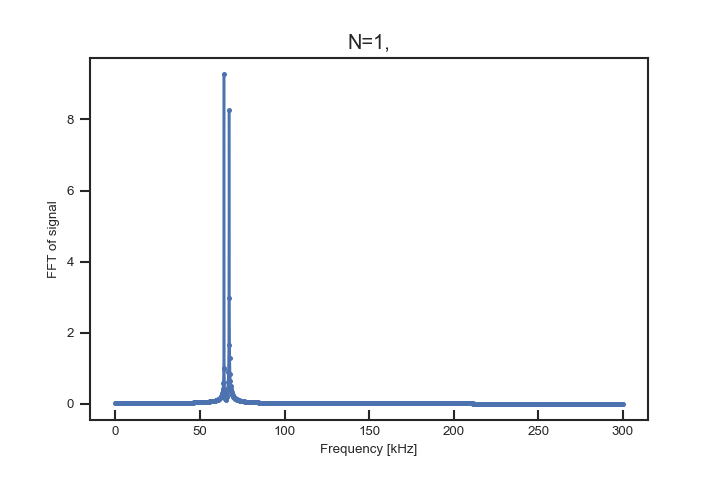

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\3821557602.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


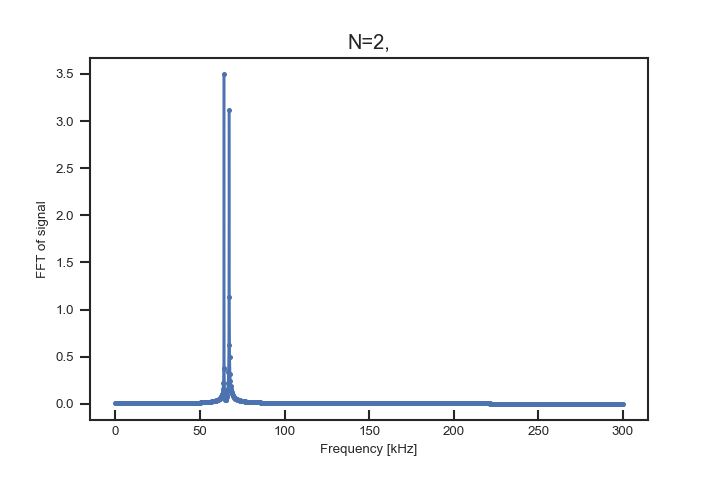

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\3821557602.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


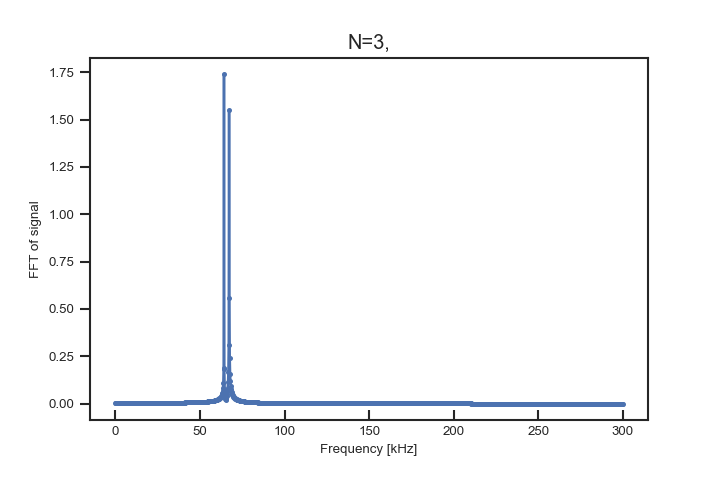

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\3821557602.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


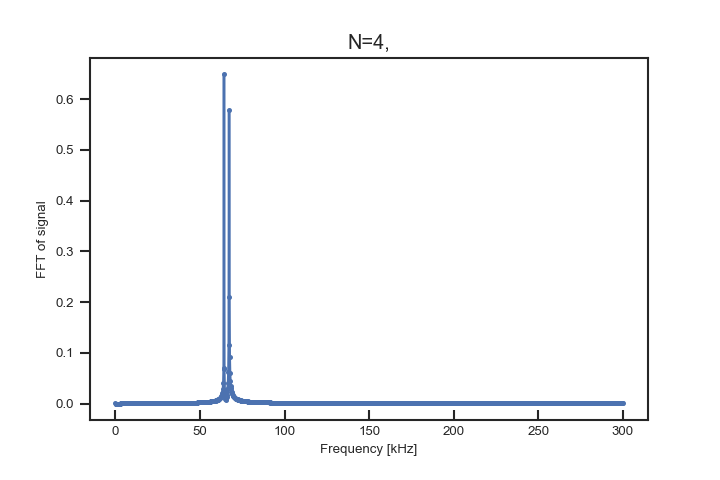

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\3821557602.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


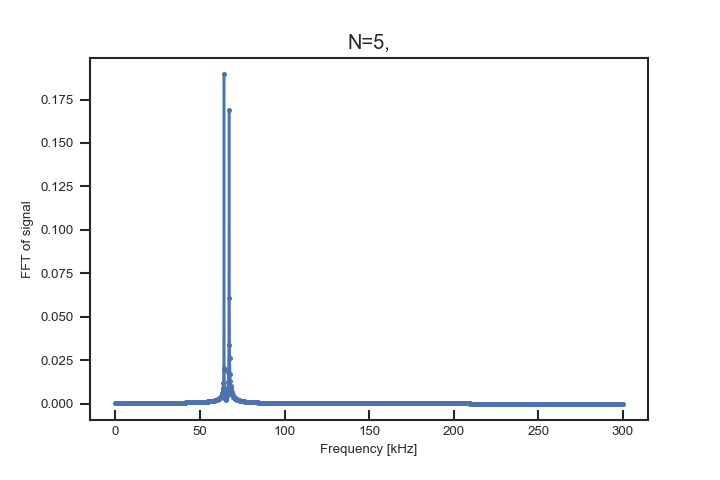

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\3821557602.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


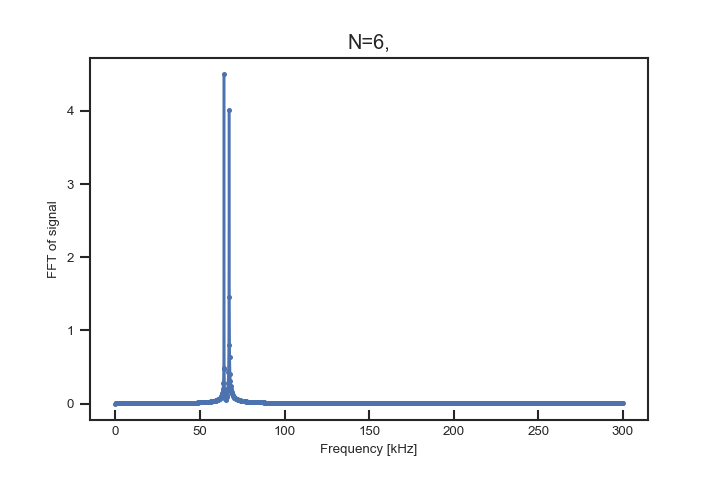

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\3821557602.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


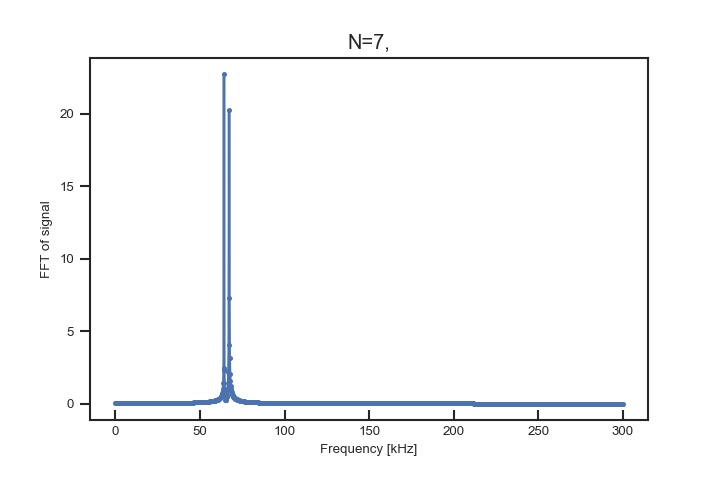

In [74]:
%matplotlib notebook

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = linspace(start,start+duration, steps) # in us
sample_rate = steps/duration # in kHz

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} ms'.format(BS_up))

fig_all,ax_all = plt.subplots(dpi=150)
tau1, tau2 = BS_up[0],BS_up[1]
for n in [1,2,3,4,5,6,7]:
    term1 = []
    term2 = []
    term3 = []
    term4 = []
    signal = []    
    for tc in tqdm.tqdm_notebook(Tc):
        term1.append(1)
        term2.append(1)
        term3.append(1)
        term4.append(1)
        for i, azz in enumerate(Azz):
            terms= ESEEM_dd(2*pi*azz, 2*pi*Azx[i], tau1, tau2, tc, N1=n,N2=n)
            term1[-1] *= terms[0]
            term2[-1] *= terms[1]
            term3[-1] *= terms[2]
            term4[-1] *= terms[3]
        signal.append((term1[-1] - term2[-1] + term3[-1] - term4[-1])/4)

    fig,ax = plt.subplots(dpi=120)
    plt.title(label='N={},'.format(n))
    ax.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha = 1)
    ax_all.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha=1,
                label='N={},'.format(n) )
    ax.set_xlabel('Frequency [kHz]')
    ax.set_ylabel('FFT of signal')

ax_all.set_xlabel(r'$\omega$ [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend()

Freq Larmor=64.2 kHz
Azz=[-204.    51.5    3. ] kHz
Azx=[ 64.4 143.6   2. ] kHz
Freq hyp up=[153.92010915 184.41108969  67.22975532] kHz
Blind Spot up=[0.00649688 0.00542267 0.01487437] ms


<IPython.core.display.Javascript object>


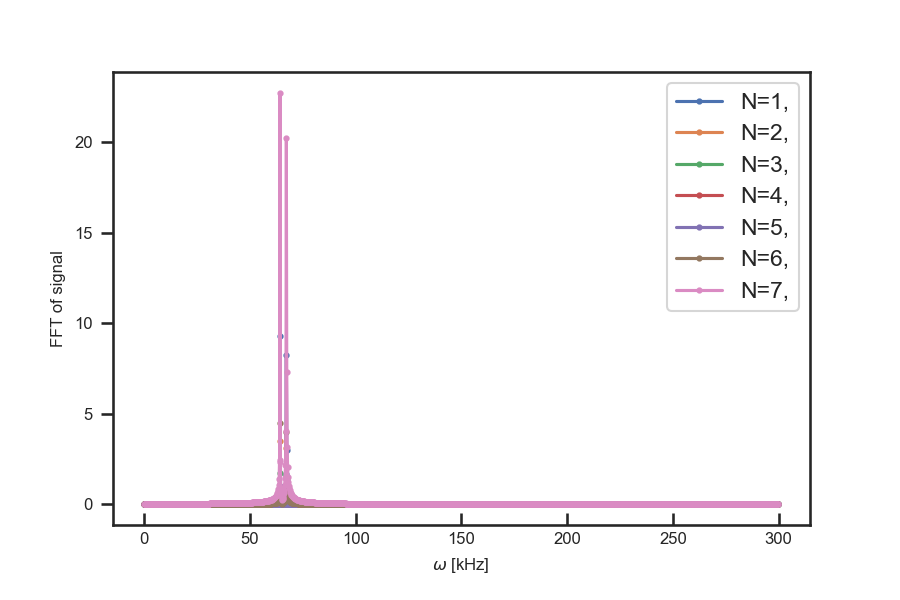

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\1373366643.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


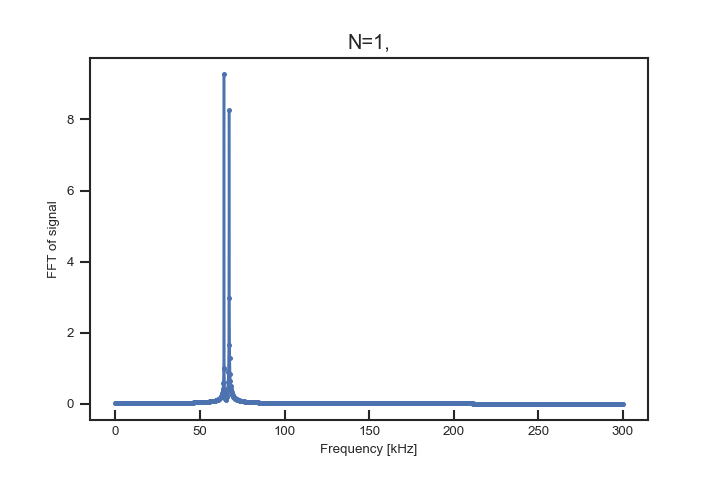

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\1373366643.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


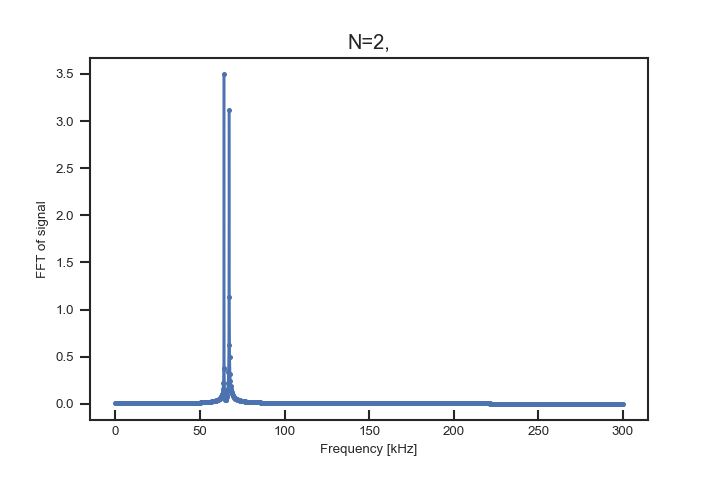

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\1373366643.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


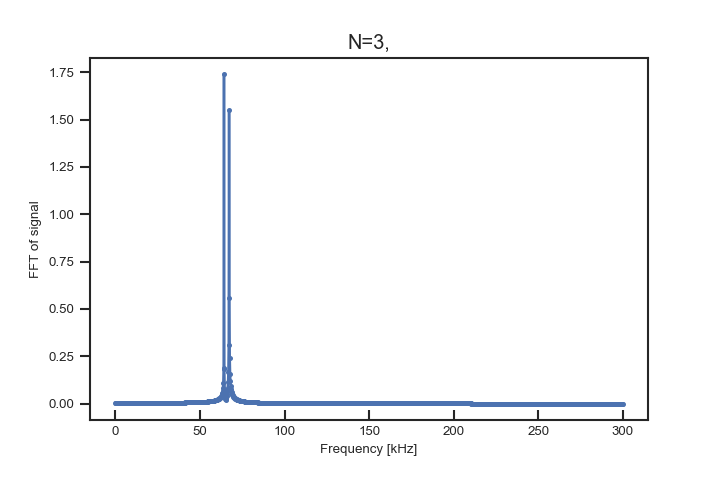

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\1373366643.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


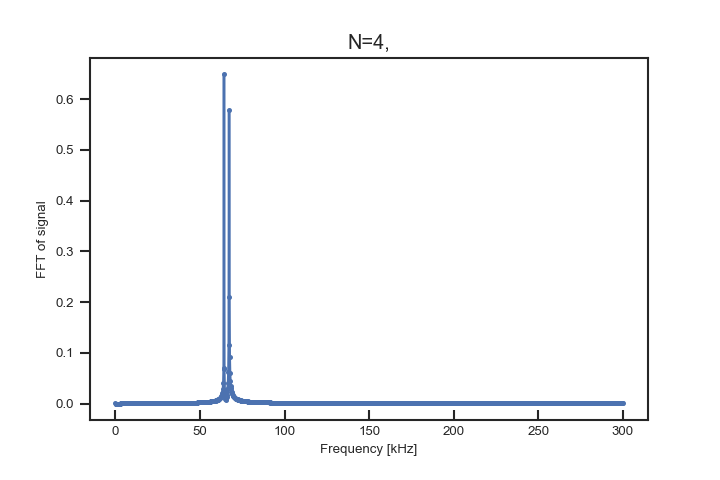

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\1373366643.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


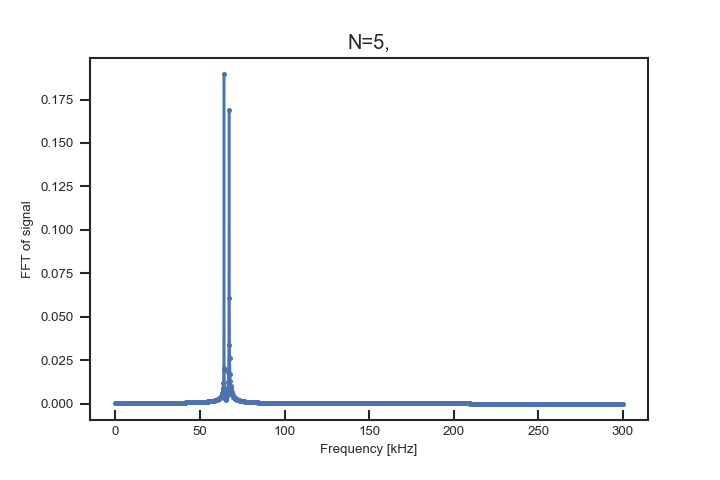

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\1373366643.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


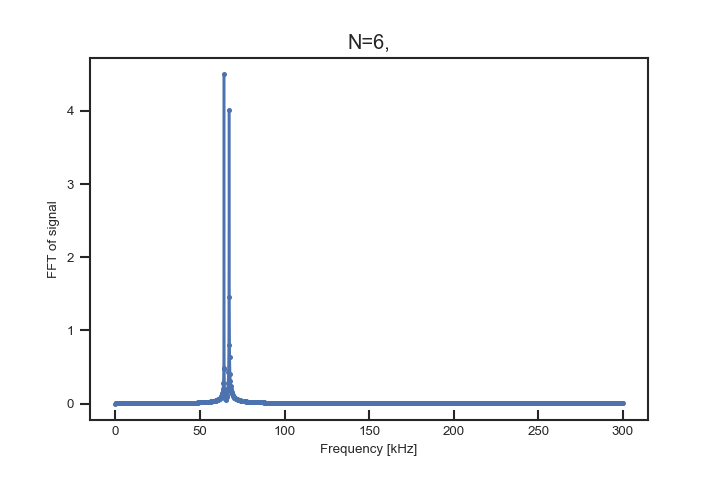

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\1373366643.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


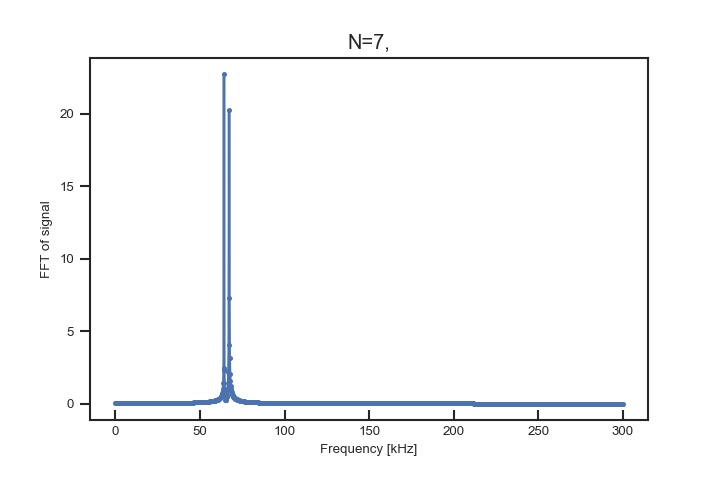

In [76]:
%matplotlib notebook

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = linspace(start,start+duration, steps) # in us
sample_rate = steps/duration # in kHz

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} ms'.format(BS_up))

fig_all,ax_all = plt.subplots(dpi=150)
tau1, tau2 = BS_up[0],BS_up[1]
for n in [1,2,3,4,5,6,7]:
    term1 = []
    term2 = []
    term3 = []
    term4 = []
    signal = []    
    for tc in tqdm.tqdm_notebook(Tc):
        term1.append(1)
        term2.append(1)
        term3.append(1)
        term4.append(1)
        for i, azz in enumerate(Azz):
            terms= five_pulse_ESEEM(2*pi*azz, 2*pi*Azx[i], tau1, tau2, tc, N=n)
            term1[-1] *= terms[0]
            term2[-1] *= terms[1]
            term3[-1] *= terms[2]
            term4[-1] *= terms[3]
        signal.append((term1[-1] - term2[-1] + term3[-1] - term4[-1])/4)

    fig,ax = plt.subplots(dpi=120)
    plt.title(label='N={},'.format(n))
    ax.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha = 1)
    ax_all.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha=1,
                label='N={},'.format(n) )
    ax.set_xlabel('Frequency [kHz]')
    ax.set_ylabel('FFT of signal')

ax_all.set_xlabel(r'$\omega$ [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend()

In [95]:
def ESEEM_pi(azz, azx, tau1, tau2, Tc, N1=1, N2=1):  # flexible but heavy code
    # N = number of pi pulses at each hahn-echo\ tau-2tau-2tau-tau-...
    H0 = WL*Iz
    H1 = (WL+azz)*Iz+azx*Ix
    
    Tau1 = np.arange(N1)*tau1 + tau1 # timing of pi pulses in a string
    Tau1 = np.append(Tau1, (N1+1)*tau1) # the last point is the end of sequence (not a pi pulse): the last evolution
    Tau2 = np.arange(N2)*tau2 + tau2
    Tau2 = np.append(Tau2, (N2+1)*tau2)
        
    
    for i, t in enumerate(Tau1):
        if i==0:
            U0 = (-1j*H0*tau1).expm()
            U1 = (-1j*H1*tau1).expm()
            continue
        u0 = (-1j*H0*(Tau1[i]-Tau1[i-1])).expm()
        u1 = (-1j*H1*(Tau1[i]-Tau1[i-1])).expm()   
        
        if (i%2)==0:
            U0 *= u0
            U1 *= u1
        else:
            U0 *= u1
            U1 *= u0
    
    W0 = (-1j*H0*Tc).expm()
    W1 = (-1j*H1*Tc).expm()
    
    for i, t in enumerate(Tau2):
        if i==0:
            V0 = (-1j*H0*tau2).expm()
            V1 = (-1j*H1*tau2).expm()
            continue
        u0 = (-1j*H0*(t-Tau2[i-1])).expm()
        u1 = (-1j*H1*(t-Tau2[i-1])).expm()   
        
        if (i%2)==0:
            V0 *= u0
            V1 *= u1
        else:
            V0 *= u1
            V1 *= u0
            
    tt1 = (V1*W0*U0*(U1.dag())*(W0.dag())*(V0.dag())).tr()
    tt2 = (V0*W0*U0*(U1.dag())*(W0.dag())*(V1.dag())).tr()
    tt3 = (V1*W1*U0*(U1.dag())*(W1.dag())*(V0.dag())).tr()
    tt4 = (V0*W1*U0*(U1.dag())*(W1.dag())*(V1.dag())).tr()
    return [tt1, tt2, tt3, tt4]

def ESEEM_pi_light(azz, azx, tau1, tau2, Tc, k=1): # k is the power of U0/ 2k-1 = N number of pi pulses
    H0 = WL*Iz
    H1 = (WL+azz)*Iz+azx*Ix
    U0 = (((-1j*H1*tau1).expm())*((-1j*H0*tau1).expm()))**k
    U1 = (((-1j*H0*tau1).expm())*((-1j*H1*tau1).expm()))**k
    W0 = (-1j*H0*Tc).expm()
    W1 = (-1j*H1*Tc).expm()
    V0 = (((-1j*H1*tau2).expm())*((-1j*H0*tau2).expm()))**k
    V1 = (((-1j*H0*tau2).expm())*((-1j*H1*tau2).expm()))**k
    
    tt1 = (V1*W0*U0*(U1.dag())*(W0.dag())*(V0.dag())).tr()
    tt2 = (V0*W0*U0*(U1.dag())*(W0.dag())*(V1.dag())).tr()
    tt3 = (V1*W1*U0*(U1.dag())*(W1.dag())*(V0.dag())).tr()
    tt4 = (V0*W1*U0*(U1.dag())*(W1.dag())*(V1.dag())).tr()
    return [tt1, tt2, tt3, tt4]
############################################################################
def no_pulse(azz, azx, tau1, tau2, Tc, N=1): # This is basically 3 pulse ESEEM
    H0 = WL*Iz
    H1 = (WL+azz)*Iz+azx*Ix
    U0 = (-1j*H0*tau1).expm()
    U1 = (-1j*H1*tau1).expm()
    W0 = (-1j*H0*Tc).expm()
    W1 = (-1j*H1*Tc).expm()
    V0 = (-1j*H0*tau2).expm()
    V1 = (-1j*H1*tau2).expm()
    
    tt1 = (V1*W0*U0*(U1.dag())*(W0.dag())*(V0.dag())).tr()
    tt2 = (V0*W0*U0*(U1.dag())*(W0.dag())*(V1.dag())).tr()
    tt3 = (V1*W1*U0*(U1.dag())*(W1.dag())*(V0.dag())).tr()
    tt4 = (V0*W1*U0*(U1.dag())*(W1.dag())*(V1.dag())).tr()
    return [tt1, tt2, tt3, tt4]

Freq Larmor=64.2 kHz
Azz=[-204.    51.5    3. ] kHz
Azx=[ 64.4 143.6   2. ] kHz
Freq hyp up=[153.92010915 184.41108969  67.22975532] kHz
Blind Spot up=[0.00649688 0.00542267 0.01487437] ms


<IPython.core.display.Javascript object>


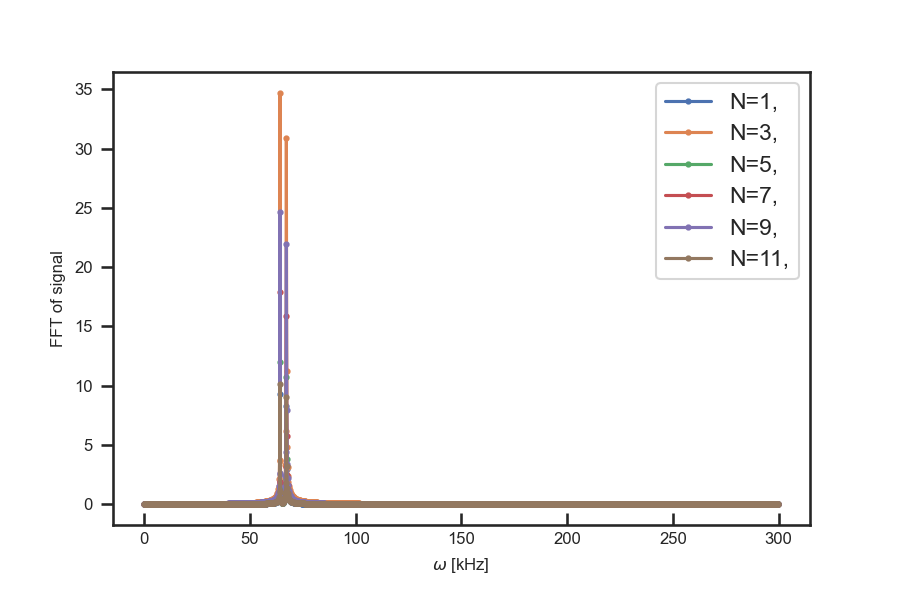

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\794994231.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


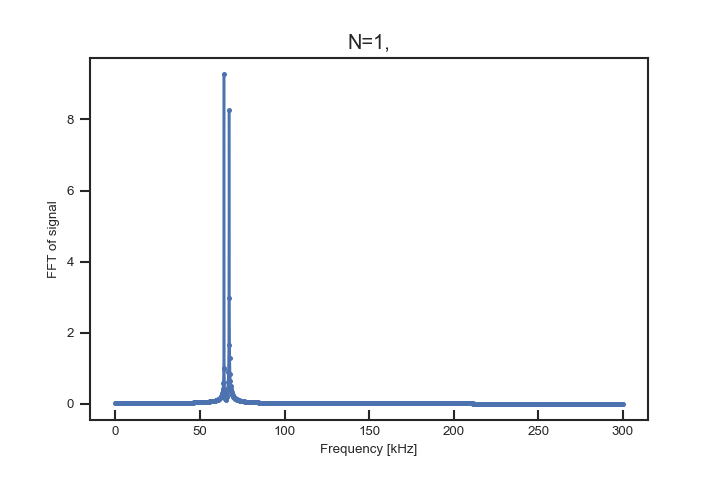

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\794994231.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


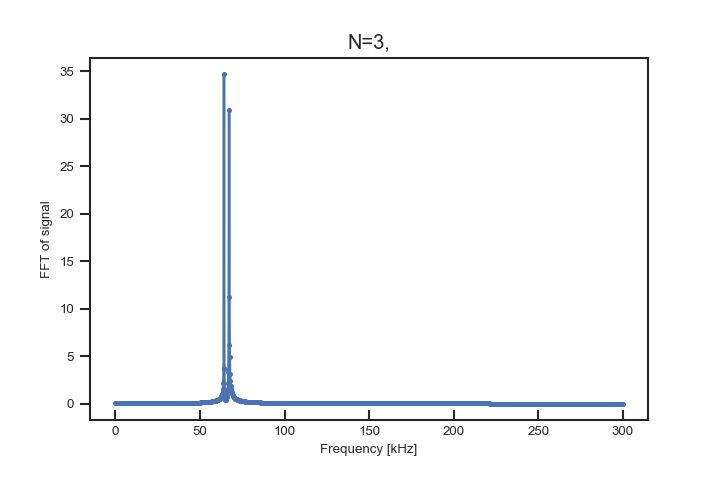

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\794994231.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


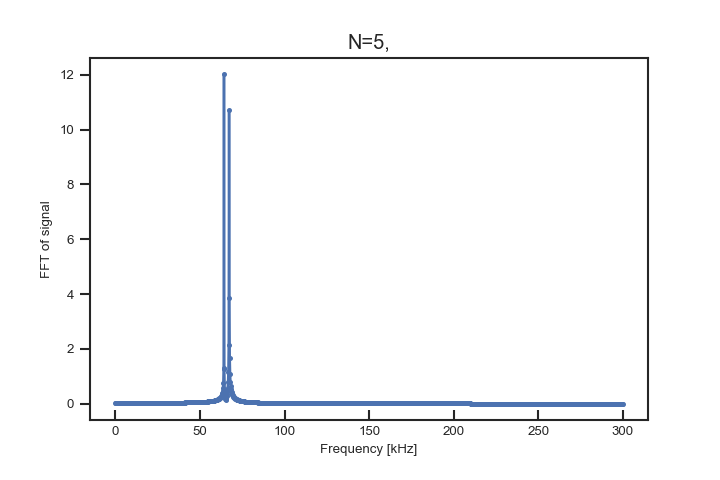

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\794994231.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


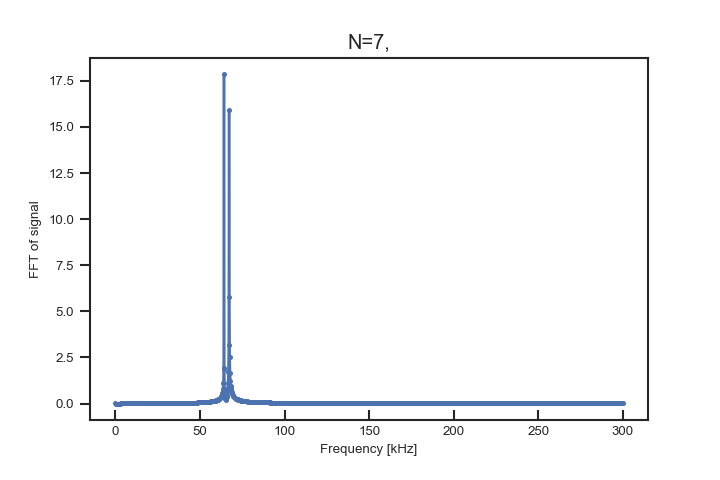

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\794994231.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


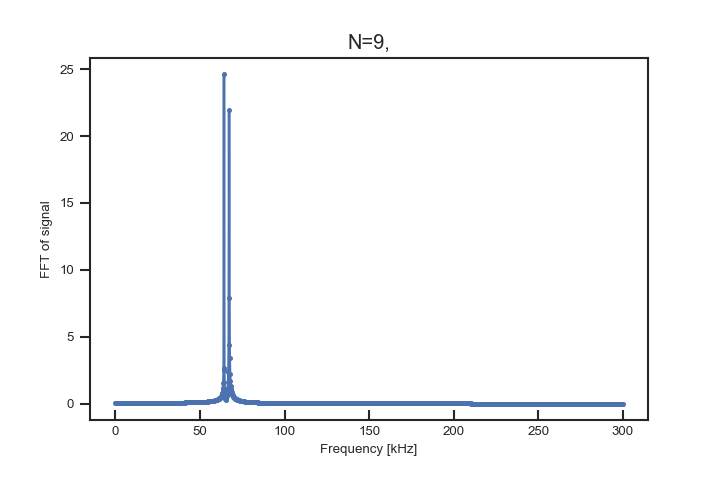

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\794994231.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


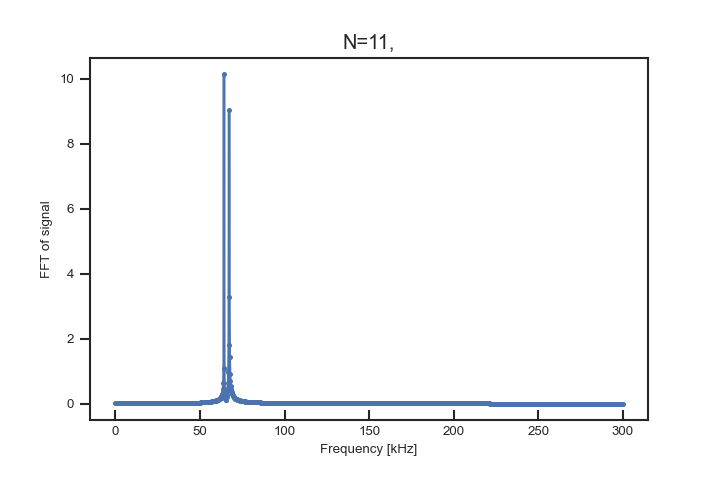

In [77]:
%matplotlib notebook

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = linspace(start,start+duration, steps) # in us
sample_rate = steps/duration # in kHz

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} ms'.format(BS_up))

fig_all,ax_all = plt.subplots(dpi=150)
tau1, tau2 = BS_up[0],BS_up[1]
for n in [1,3,5,7,9,11]:
    term1 = []
    term2 = []
    term3 = []
    term4 = []
    signal = []    
    for tc in tqdm.tqdm_notebook(Tc):
        term1.append(1)
        term2.append(1)
        term3.append(1)
        term4.append(1)
        for i, azz in enumerate(Azz):
            terms= ESEEM_pi(2*pi*azz, 2*pi*Azx[i], tau1, tau2, tc, N1=n,N2=n)
            term1[-1] *= terms[0]
            term2[-1] *= terms[1]
            term3[-1] *= terms[2]
            term4[-1] *= terms[3]
        signal.append((term1[-1] - term2[-1] + term3[-1] - term4[-1])/4)

    fig,ax = plt.subplots(dpi=120)
    plt.title(label='N={},'.format(n))
    ax.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha = 1)
    ax_all.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha=1,
                label='N={},'.format(n) )
    ax.set_xlabel('Frequency [kHz]')
    ax.set_ylabel('FFT of signal')
    
ax_all.set_xlabel(r'$\omega$ [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend()

Freq Larmor=64.2 kHz
Azz=[-204.    51.5    3. ] kHz
Azx=[ 64.4 143.6   2. ] kHz
Freq hyp up=[153.92010915 184.41108969  67.22975532] kHz
Blind Spot up=[0.00649688 0.00542267 0.01487437] ms


<IPython.core.display.Javascript object>


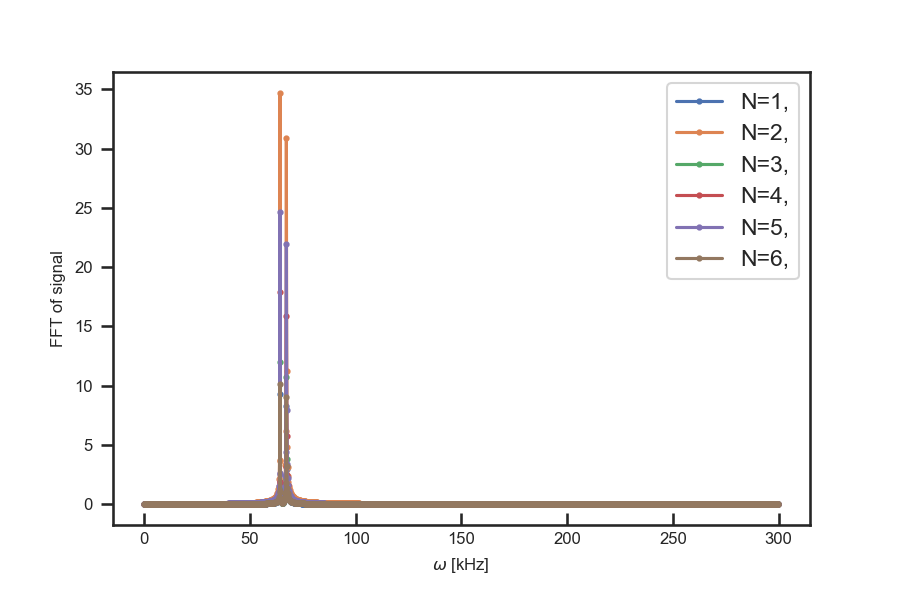

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\2505671774.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


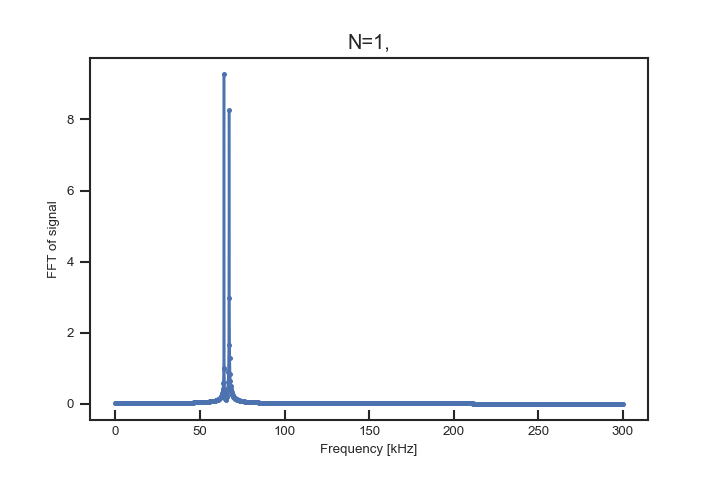

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\2505671774.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


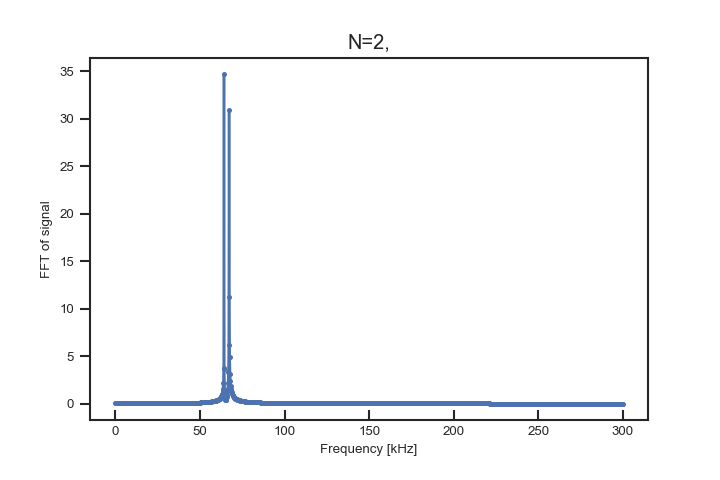

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\2505671774.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


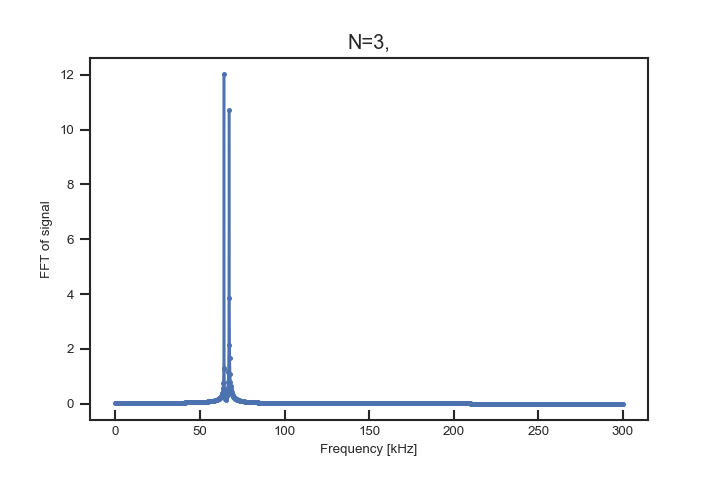

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\2505671774.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


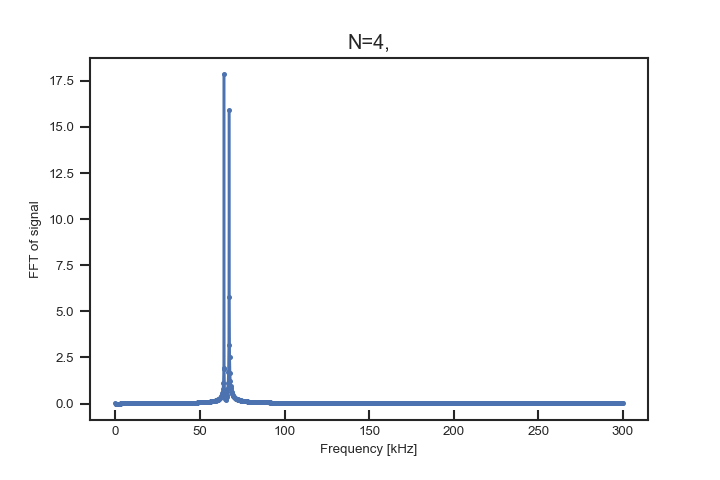

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\2505671774.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


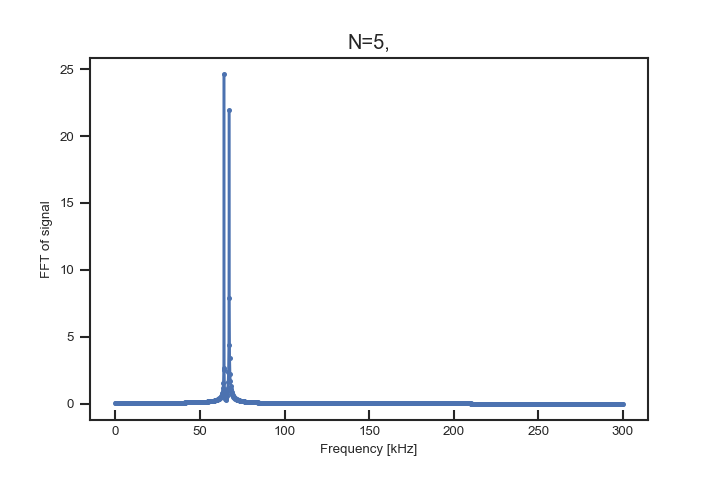

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\2505671774.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


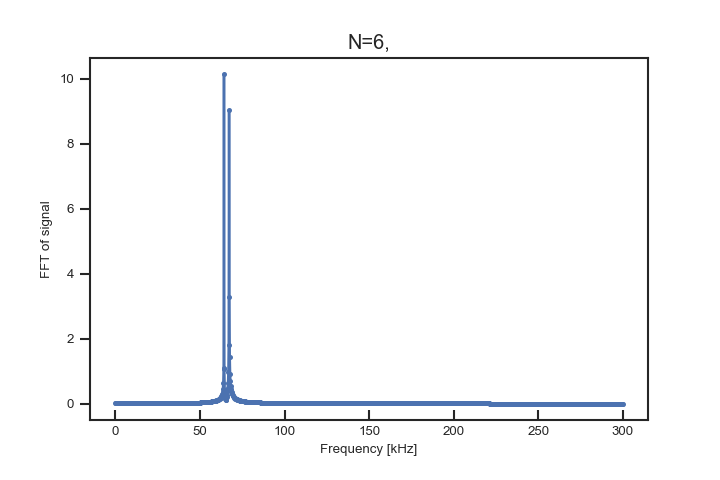

In [78]:
%matplotlib notebook

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = linspace(start,start+duration, steps) # in us
sample_rate = steps/duration # in kHz

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} ms'.format(BS_up))

fig_all,ax_all = plt.subplots(dpi=150)
tau1, tau2 = BS_up[0],BS_up[1]
for n in [1,2,3,4,5,6]:
    term1 = []
    term2 = []
    term3 = []
    term4 = []
    signal = []    
    for tc in tqdm.tqdm_notebook(Tc):
        term1.append(1)
        term2.append(1)
        term3.append(1)
        term4.append(1)
        for i, azz in enumerate(Azz):
            terms= ESEEM_pi_light(2*pi*azz, 2*pi*Azx[i], tau1, tau2, tc, k = n)
            term1[-1] *= terms[0]
            term2[-1] *= terms[1]
            term3[-1] *= terms[2]
            term4[-1] *= terms[3]
        signal.append((term1[-1] - term2[-1] + term3[-1] - term4[-1])/4)

    fig,ax = plt.subplots(dpi=120)
    plt.title(label='N={},'.format(n))
    ax.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha = 1)
    ax_all.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha=1,
                label='N={},'.format(n) )
    ax.set_xlabel('Frequency [kHz]')
    ax.set_ylabel('FFT of signal')
    
ax_all.set_xlabel(r'$\omega$ [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend()

# Multiplication of two sequence

In [88]:
def ESEEM_dd_multi(azz, azx, N1, tau1, N2, tau2, tau3, Tc): # N1 2.tau1 = N2 2.tau2
    # N = number of pi pulses at each hahn-echo\ tau-2tau-2tau-tau-...
    H0 = WL*Iz
    H1 = (WL+azz)*Iz+azx*Ix

    Tau1 = np.arange(N1)*(2*tau1) + tau1 # timing of pi pulses in a string
    Tau2 = np.arange(N2)*(2*tau2) + tau2 
    
    Tauuu = np.concatenate((Tau1,Tau2),axis=0)
    Tauuu = np.sort(Tauuu)
    Tauuu = np.append(Tauuu, N2*2*tau2)  # the last point is the end of sequence (not a pi pulse): the last evolution
    
    
    for i, t in enumerate(Tauuu):
        if i==0:
            U0 = (-1j*H0*t).expm()
            U1 = (-1j*H1*t).expm()
            continue
        u0 = (-1j*H0*(t-Tauuu[i-1])).expm()
        u1 = (-1j*H1*(t-Tauuu[i-1])).expm()
        if (i%2)==0:
            U0 *= u0
            U1 *= u1
        else:
            U0 *= u1
            U1 *= u0
    
    W0 = (-1j*H0*Tc).expm()
    W1 = (-1j*H1*Tc).expm()
    V0 = ((-1j*H1*tau3).expm())*((-1j*H0*tau3).expm())
    V1 = ((-1j*H0*tau3).expm())*((-1j*H1*tau3).expm())
                
    tt1 = (V1*W0*U0*(U1.dag())*(W0.dag())*(V0.dag())).tr()
    tt2 = (V0*W0*U0*(U1.dag())*(W0.dag())*(V1.dag())).tr()
    tt3 = (V1*W1*U0*(U1.dag())*(W1.dag())*(V0.dag())).tr()
    tt4 = (V0*W1*U0*(U1.dag())*(W1.dag())*(V1.dag())).tr()
    return [tt1, tt2, tt3, tt4]

Freq Larmor=64.2 kHz
Azz=[ 64.2 128.4   3. ] kHz
Azx=[ 64.2        212.92731154   2.        ] kHz
Freq hyp up=[143.55556416 287.11112831  67.22975532] kHz
Blind Spot up=[0.00696594 0.00348297 0.01487437] ms


<IPython.core.display.Javascript object>


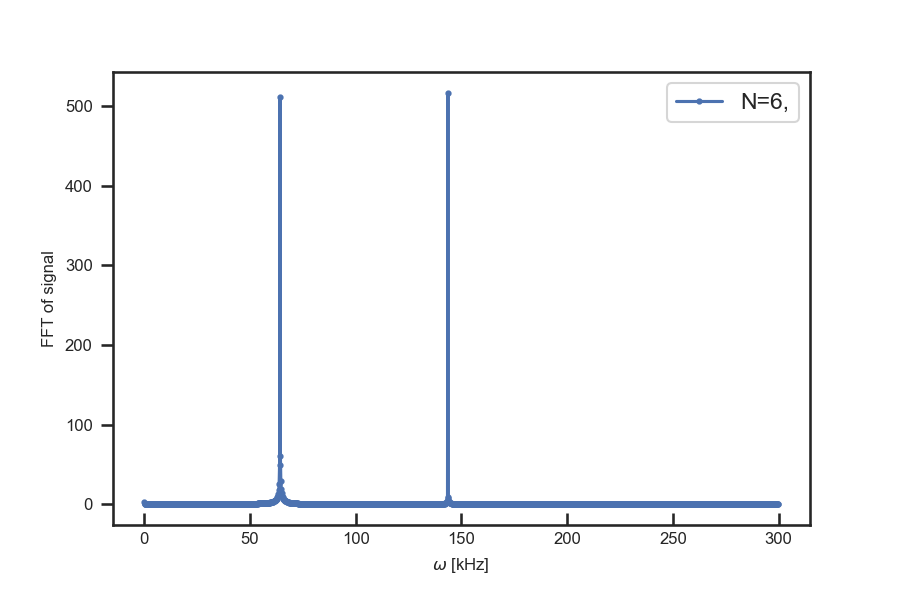

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\947991837.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


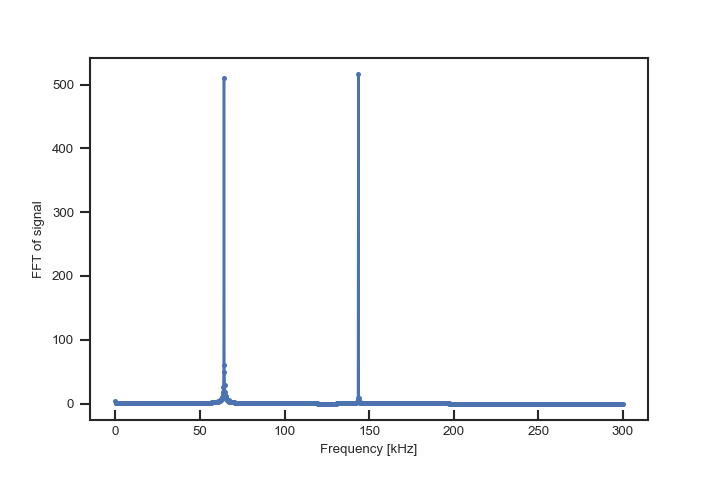

In [105]:
%matplotlib notebook
# determining the parameters
fL = 1.07*60 # kHz
WL = 2*pi*1.07*60 # kHz
Azz = np.array([fL, 2*fL, 3]) # kHz
Azx = np.array([fL, np.sqrt(11)*fL, 2]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = linspace(start,start+duration, steps) # in us
sample_rate = steps/duration # in kHz

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} ms'.format(BS_up))

fig_all,ax_all = plt.subplots(dpi=150)
for tau1, tau2, tau3 in [[BS_up[0],BS_up[1],0.5*BS_up[2]]]:
    term1 = []
    term2 = []
    term3 = []
    term4 = []
    signal = []    
    for tc in tqdm.tqdm_notebook(Tc):
        term1.append(1)
        term2.append(1)
        term3.append(1)
        term4.append(1)
        for i, azz in enumerate(Azz):
            terms= ESEEM_dd_multi(2*pi*azz, 2*pi*Azx[i],1, tau1, 2, tau2, tau3, tc)
            term1[-1] *= terms[0]
            term2[-1] *= terms[1]
            term3[-1] *= terms[2]
            term4[-1] *= terms[3]
        signal.append((term1[-1] - term2[-1] + term3[-1] - term4[-1])/4)

    fig,ax = plt.subplots(dpi=120)
    #plt.title(label='N={},'.format(n))
    ax.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha = 1)
    ax_all.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha=1,
                label='N={},'.format(n) )
    ax.set_xlabel('Frequency [kHz]')
    ax.set_ylabel('FFT of signal')

ax_all.set_xlabel(r'$\omega$ [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend()

In [97]:
def ESEEM_pi_multi(azz, azx, N1, tau1, N2, tau2, tau3, Tc): # N1 2.tau1 = N2 2.tau2
    # N = number of pi pulses at each hahn-echo\ tau-2tau-2tau-tau-...
    H0 = WL*Iz
    H1 = (WL+azz)*Iz+azx*Ix

    Tau1 = np.arange(N1)*tau1 + tau1 # timing of pi pulses in a string
    Tau2 = np.arange(N2)*tau2 + tau2
    Tauuu = np.concatenate((Tau1,Tau2),axis=0)
    Tauuu = np.sort(Tauuu)
    Tauuu = np.append(Tauuu, (N2+1)*tau2)  # the last point is the end of sequence (not a pi pulse): the last evolution
    
    
    for i, t in enumerate(Tauuu):
        if i==0:
            U0 = (-1j*H0*t).expm()
            U1 = (-1j*H1*t).expm()
            continue
        u0 = (-1j*H0*(t-Tauuu[i-1])).expm()
        u1 = (-1j*H1*(t-Tauuu[i-1])).expm()
        if (i%2)==0:
            U0 *= u0
            U1 *= u1
        else:
            U0 *= u1
            U1 *= u0
    
    W0 = (-1j*H0*Tc).expm()
    W1 = (-1j*H1*Tc).expm()
    V0 = ((-1j*H1*tau3).expm())*((-1j*H0*tau3).expm())
    V1 = ((-1j*H0*tau3).expm())*((-1j*H1*tau3).expm())
                
    tt1 = (V1*W0*U0*(U1.dag())*(W0.dag())*(V0.dag())).tr()
    tt2 = (V0*W0*U0*(U1.dag())*(W0.dag())*(V1.dag())).tr()
    tt3 = (V1*W1*U0*(U1.dag())*(W1.dag())*(V0.dag())).tr()
    tt4 = (V0*W1*U0*(U1.dag())*(W1.dag())*(V1.dag())).tr()
    return [tt1, tt2, tt3, tt4]

Freq Larmor=64.2 kHz
Azz=[-204.    51.5    3. ] kHz
Azx=[ 64.4 143.6   2. ] kHz
Freq hyp up=[153.92010915 184.41108969  67.22975532] kHz
Blind Spot up=[0.00649688 0.00542267 0.01487437] ms


<IPython.core.display.Javascript object>


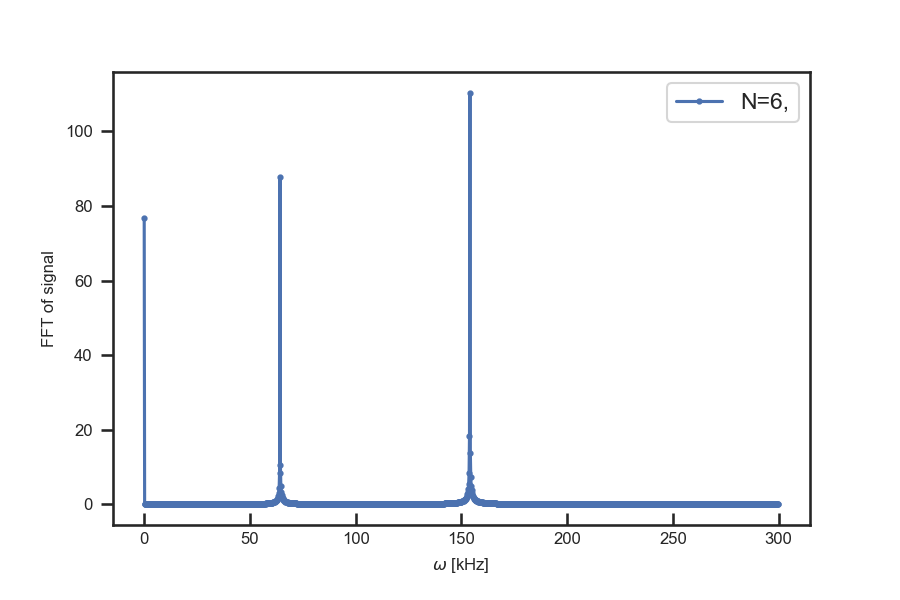

C:\Users\yy3\AppData\Local\Temp\ipykernel_6852\2198553918.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tc in tqdm.tqdm_notebook(Tc):


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


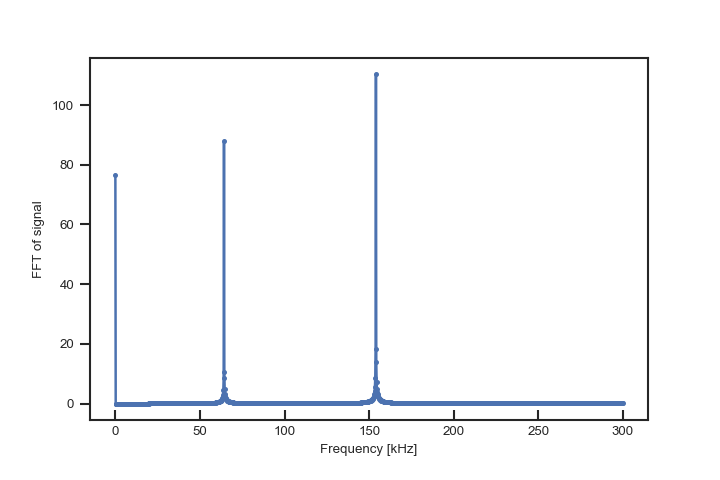

In [100]:
%matplotlib notebook

start = 1e-3 # in ms
duration = 5 # in ms
steps = 3000
Tc = linspace(start,start+duration, steps) # in us
sample_rate = steps/duration # in kHz

print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} ms'.format(BS_up))

fig_all,ax_all = plt.subplots(dpi=150)
for tau1, tau2, tau3 in [[BS_up[0],BS_up[1], 0.5*BS_up[2]]]:
    term1 = []
    term2 = []
    term3 = []
    term4 = []
    signal = []    
    for tc in tqdm.tqdm_notebook(Tc):
        term1.append(1)
        term2.append(1)
        term3.append(1)
        term4.append(1)
        for i, azz in enumerate(Azz):
            terms= ESEEM_pi_multi(2*pi*azz, 2*pi*Azx[i], 5, tau1, 6, tau2, tau3, tc)
            term1[-1] *= terms[0]
            term2[-1] *= terms[1]
            term3[-1] *= terms[2]
            term4[-1] *= terms[3]
        signal.append((term1[-1] - term2[-1] + term3[-1] - term4[-1])/4)

    fig,ax = plt.subplots(dpi=120)
    #plt.title(label='N={},'.format(n))
    ax.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha = 1)
    ax_all.plot(fftfreq(steps, 1/sample_rate)[0:int(steps/2)], np.abs(fft(signal))[0:int(steps/2)],'-o',markersize=2, alpha=1,
                label='N={},'.format(n) )
    ax.set_xlabel('Frequency [kHz]')
    ax.set_ylabel('FFT of signal')

ax_all.set_xlabel(r'$\omega$ [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend()

In [104]:
0.00348297*2

0.00696594